In [54]:
import numpy as np
import pandas as pd
from CHEM274.importer_snippets import load_experiment
from scipy.signal import find_peaks, savgol_filter
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
plt.style.use('JGW-PPT')
import os

In [55]:
# Import Data
FcMeCN = load_experiment(csv_dirname=r"..\data\CV_Fc_GC_MeCN_0.1Vs-1_P-06-04")
FcMeAc = load_experiment(csv_dirname=r"..\data\CV_Fc_GC_MeAc_0.1Vs-1_P-07-02")
FcMix = load_experiment(csv_dirname=r"..\data\CV_Fc_GC_mix_0.1Vs-1_P-08-13")
FcStar = load_experiment(csv_dirname=r"..\data\CV_FcStar_GC_MeAc_0.1Vs-1_P-09-03")

exp_series = [FcMeCN, FcMeAc, FcMix, FcStar]
# exp_series = [FcMeCN]

i = 0 # for indexing arrays
ref_check = [False, False, True, True]
Ru = np.array([404, 400, 403, 444]) # Ohms
# pp_width = np.array([3600, 3600, 3600, 100])

picked_peaks = []

for exp in exp_series:
    # print(i, ref_check[i], Ru[i], sep='\n')
    # Reference calibration
    if ref_check[i]:
        exp.data['Ecell'] = exp.data['Ecell'] - 0.101984 # Apply iR correction for Ru determined by EIS fitting to the Randles circuit


    exp.data['Ecell'] = exp.data['Ecell'] - (Ru[i] * exp.data['iw'].abs()) # 100% Compensation!

    # Figure out what the real h_time was. This is different from the programmed h_time due to automatic sample number rounding during acquisition.
    h_pot = exp.data.loc[0, 'E_program']
    h_time = exp.data.loc[exp.data['E_program'] > h_pot]['t'].min()
    # Put it in params
    h_time_row = pd.Series(['h_time', h_time], index=['parameter', 'value'])
    exp.params = exp.params.append(h_time_row, ignore_index=True)

    scan_direction_bools = []

    Ecell_lead_time = .18 # Manually set delay parameter in seconds
    switching_time = (h_time + exp.data['t'].max()) / 2 - Ecell_lead_time
    for j in range(len(exp.data['E_program'])):
        # This checks every data point individually, so it's a bit slow
        if exp.data.loc[j, 't'].item() < h_time:
            scan_direction_bools.append(None)
        elif exp.data.loc[j, 't'].item() < switching_time:
            scan_direction_bools.append(True)
        else:
            scan_direction_bools.append(False)
    exp.data['forward'] = scan_direction_bools

    # Smooth data using the Savitski Golay method
    exp.data['savgol_iw'] = savgol_filter(exp.data['iw'], 25, 3)

    i+=1

C:\Users\jgage\anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


i: 0
sub_ipa: 1.6022659995448084e-05
sub_ipc: -1.938751160499462e-05
-ipa/ipc: 0.8264423161619316


C:\Users\jgage\anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


i: 1
sub_ipa: 2.257511862376018e-05
sub_ipc: -3.0261571537738307e-05
-ipa/ipc: 0.7459995458466994


C:\Users\jgage\anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\jgage\AppData\Local\Temp/ipykernel_9896/3384585050.py:18: PeakPropertyWarning: some peaks have a width of 0
  find_ipa = find_peaks(exp.data['savgol_iw'], height=0, width=3600) # Must give minimum height to get peak_heights dict.
C:\Users\jgage\anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


i: 2
sub_ipa: 2.004825479396711e-05
sub_ipc: -2.3433170824813148e-05
-ipa/ipc: 0.8555502344880367
i: 3
sub_ipa: 1.9501854200955085e-05
sub_ipc: -2.1367132349321414e-05
-ipa/ipc: 0.9127033933299165


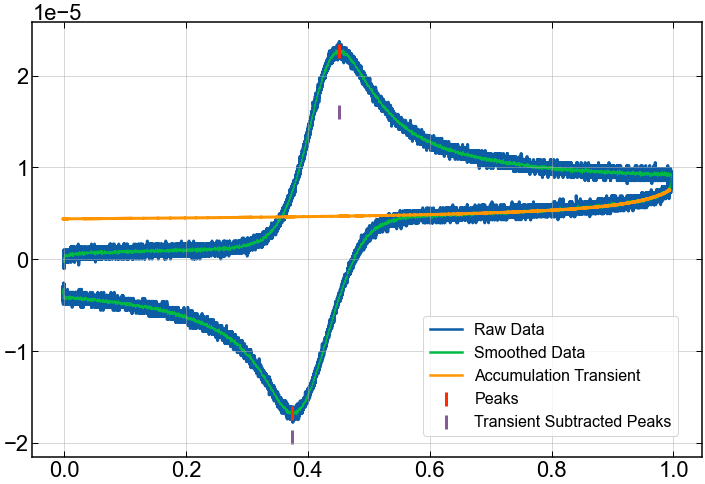

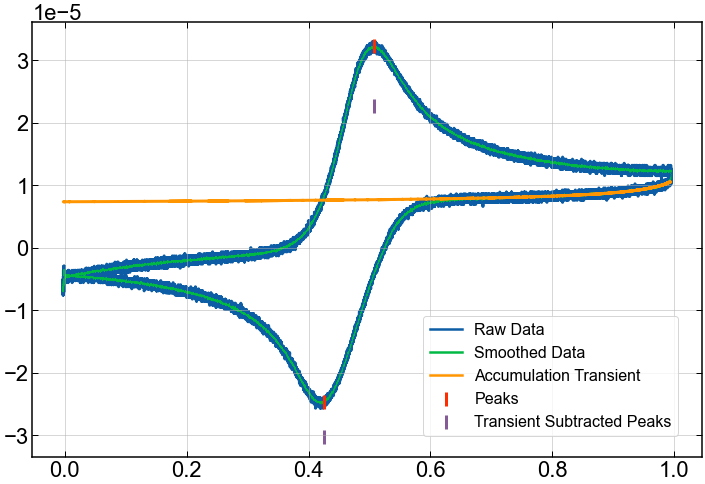

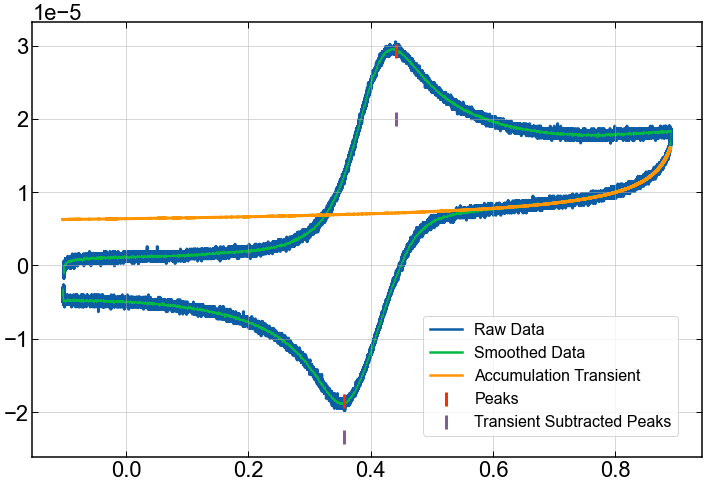

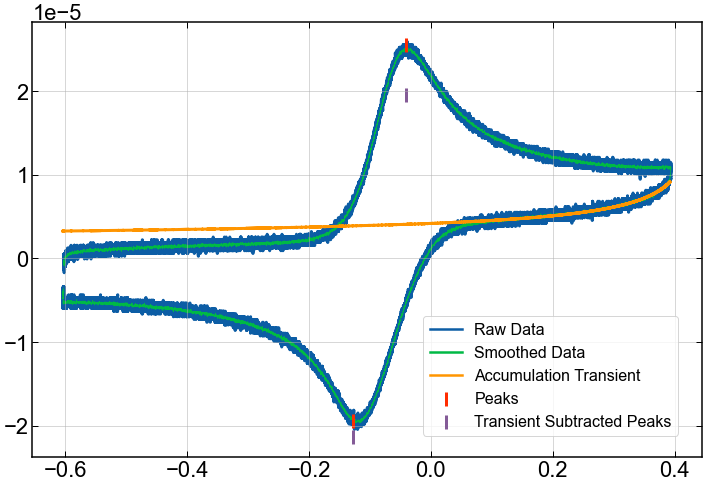

In [61]:
def func(t, a, b, t0):
    return (a / np.sqrt(t-t0)) + b

charging_current_at_peak = 2.0e-6 # an estimate at 100 mV/s from Cdl series CVs.
i=0
for exp in exp_series:

    fit_length = 0.3 # Length of transient to fit in V
    switch_pot = exp.data.loc[exp.data['forward']==True]['Ecell'].max()
    trans_t = exp.data.loc[exp.data['forward']==False].loc[exp.data['Ecell'].between(switch_pot - fit_length, switch_pot)]['t']
    trans_E = exp.data.loc[exp.data['forward']==False].loc[exp.data['Ecell'].between(switch_pot - fit_length, switch_pot)]['Ecell']
    trans_i = exp.data.loc[exp.data['forward']==False].loc[exp.data['Ecell'].between(switch_pot - fit_length, switch_pot)]['savgol_iw']

    guesses = np.array([1.0e-5, 5.0e-5, 1])
    fit, cov = curve_fit(func, trans_t, trans_i, guesses)

    # Maxima
    find_ipa = find_peaks(exp.data['savgol_iw'], height=0, width=3600) # Must give minimum height to get peak_heights dict.
    ipa, Epa = exp.data['iw'][find_ipa[0]].to_numpy(), exp.data['Ecell'][find_ipa[0]].to_numpy()

    # Invert signal to find minima - Signals are negative but indicies are correct!
    find_ipc = find_peaks(-exp.data['savgol_iw'], height=0, width=3600) # Remember to un-invert anytime if calling ipc values from find_ipc, but not indices.
    ipc, Epc = exp.data['iw'][find_ipc[0]].to_numpy(), exp.data['Ecell'][find_ipc[0]].to_numpy()

    peaks = {'ipa': ipa[0], 'Epa': Epa[0], 'ipc': ipc[0], 'Epc': Epc[0]}
    picked_peaks.append(pd.DataFrame(data=peaks, index=[0]))


    sub_ipa = ipa[0] - func(exp.data.loc[exp.data['forward']==False].loc[exp.data['Ecell'].between(Epa[0]-2e-4, Epa[0]+2e-4)]['t'].median(), *fit) - charging_current_at_peak
    # sub_ipa = ipa[0]
    sub_ipc = ipc[0] - func(exp.data.loc[exp.data['forward']==False].loc[exp.data['Ecell']==Epc[0]]['t'].mean(), *fit) + charging_current_at_peak

    peak_pots = np.array([Epa[0], Epc[0]])
    sub_peaks = np.array([sub_ipa, sub_ipc])

    fig, ax = plt.subplots()
    ax.tick_params(axis='both', which='both', direction='in', right=True, top=True)
    # ax.plot(exp.data['Ecell'], exp.data['iw'], label = '$v=$ '+str(exp.params.loc[exp.params['parameter']=='scan_rate', 'value'].item()) + ' V/s', zorder=0)
    ax.plot(exp.data['Ecell'], exp.data['iw'], label = 'Raw Data', zorder=0)
    ax.plot(exp.data['Ecell'], exp.data['savgol_iw'], color='C2', label='Smoothed Data', lw=.5, zorder=.2)
    ax.scatter([*Epa, *Epc], [*ipa, *ipc], color='C1', label='Peaks', marker='|', s=200, zorder=1)
    ax.plot(exp.data.loc[exp.data['forward']==False]['Ecell'], func(exp.data.loc[exp.data['forward']==False]['t'], *fit), label='Accumulation Transient', c='C3')
    ax.scatter(peak_pots, sub_peaks, label='Transient Subtracted Peaks', marker='|', s=200, c='C4')
    leg = fig.legend(loc=(0.6, 0.1))
    for line in leg.get_lines():
        line.set_linewidth(2.5)

    print('i: '+str(i))
    print('sub_ipa: '+str(sub_ipa))
    print('sub_ipc: '+str(sub_ipc))
    print('-ipa/ipc: '+str(-sub_ipa/sub_ipc), end='\n')
    i+=1